<a href="https://colab.research.google.com/github/costpetrides/Temperature_Forecasting_MethodComparison/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)


df = pd.read_csv("/content/Athens_meteo.csv",
                 parse_dates=['DAY'],  # change to date time format
                 index_col="DAY")

df = df[['T_mean', 'RH_max', 'RH_mean', 'RH_min', 'P_max','P_mean', 'P_min', 'Rain', 'U', 'U_max']]

df.head()

,T_mean,RH_max,RH_mean,RH_min,P_max,P_mean,P_min,Rain,U,U_max
DAY,,,,,,,,,,
2010-01-01,18.100,61.400,91,33,1003.600,1006.300,1002.000,0.200,4.000,12.700
2010-01-02,15.700,57.400,70,45,1005.200,1008.700,1001.500,0.000,6.800,20.700
2010-01-03,13.600,56.000,76,39,1011.700,1016.700,1008.600,0.000,5.000,15.400
2010-01-04,9.600,50.700,60,38,1021.300,1023.100,1016.800,0.000,4.300,11.000
2010-01-05,13.500,70.500,82,54,1018.700,1022.100,1015.500,0.000,7.900,19.800


Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 0.2196 - mae: 0.3418 - val_loss: 0.0727 - val_mae: 0.2033 - learning_rate: 0.0010
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0846 - mae: 0.2269 - val_loss: 0.0697 - val_mae: 0.1993 - learning_rate: 0.0010
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0752 - mae: 0.2109 - val_loss: 0.0539 - val_mae: 0.1738 - learning_rate: 0.0010
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0660 - mae: 0.1996 - val_loss: 0.0587 - val_mae: 0.1882 - learning_rate: 0.0010
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0571 - mae: 0.1840 - val_loss: 0.0459 - val_mae: 0.1611 - learning_rate: 0.0010
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0541 - mae: 0.1785 - val_loss: 0.0388 - val_mae: 0.1444 - learning_rate: 0.0010
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0532 - mae: 0.1757 - val_loss: 0.0376 - val_mae: 0.1456 - learning_r

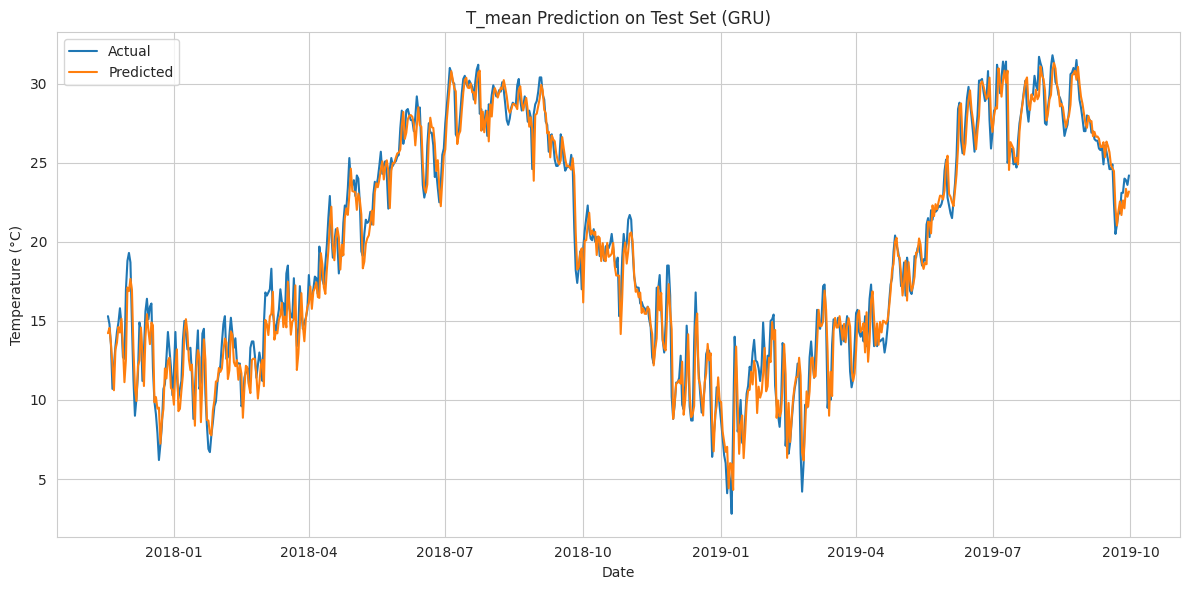

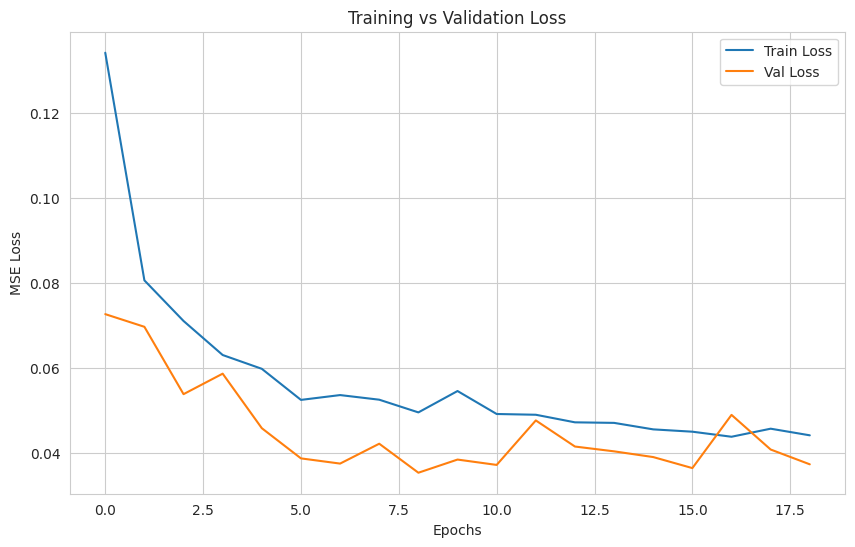

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# ─────────────────────────────────────────────────────────────
# Step 1: Add seasonal features
df['dayofyear'] = df.index.dayofyear
df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365.0)

# Step 2: Feature selection
features = ['T_mean', 'RH_mean', 'P_mean', 'sin_doy', 'cos_doy']
target = 'T_mean'
window = 30

# Step 3: Prepare full feature and target arrays
X_full = df[features].values
y_full = df[[target]].values

# Step 4: Chronological train/test split (80%/20%)
split_index = int(len(df) * 0.8)
X_train_raw = X_full[:split_index]
X_test_raw = X_full[split_index:]
y_train_raw = y_full[:split_index]
y_test_raw = y_full[split_index:]

# Step 5: Scale features and target using only training data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

# Step 6: Create time series sequences
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, window)

# ─────────────────────────────────────────────────────────────
# Step 7: Build GRU model
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(window, len(features))),
    Dropout(0.3),
    GRU(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae']
)

# Step 7.5: Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)

# Step 8: Train model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ─────────────────────────────────────────────────────────────
# Step 9: Evaluate model on test set
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("="*40)
print(" Model Evaluation on Test Set")
print("="*40)
print(f"MAE       : {mae:.2f} °C")
print(f"RMSE      : {rmse:.2f} °C")
print(f"R² Score  : {r2:.3f}")
print("="*40)

# Step 10: Reconstruct aligned test dates after sequence window
test_index_start = split_index + window
aligned_test_index = df.index[test_index_start:test_index_start + len(y_test_seq)]

# Create DataFrame with predictions
df_preds = pd.DataFrame({
    'Date': aligned_test_index,
    'Actual': y_true.flatten(),
    'Predicted': y_pred.flatten()
}).set_index('Date')

# Step 11: Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(df_preds.index, df_preds['Actual'], label='Actual')
plt.plot(df_preds.index, df_preds['Predicted'], label='Predicted')
plt.title('T_mean Prediction on Test Set (GRU)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("="*40)

# Step 12: Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()
